# Naïve K-Means

My implementation of the standard K-means algorithm also called 'Lloyd's Algorithm' which is a famouse clustering algorithm, but different implementations exists.

1. Pick $k$ number of cluster centroids, $m$ 
2. Loop through every point $x_p$ and check which $m$ is the closest and assign $x_p$ to that centroid array
3. Based on the new assignments, calculate the mean of every $m$ to get the new $m_{new} \in M$ centroids
4. Repeat until convergence


Matrix $M$ contains all vectors $m$ representing the centroids. The shape of $M$ is the rows of $m_i$ times $k$ 

Matrix $X$ contains all unassigned data points.

Matrix $S$ contains all assigned points $x_p$ which is used to calculate the mean of the new vector $m_{new}$ and assign it to the same position in $M$ 

Both functions return S which at every index $k - 1$ contains the vectors assigned to closest centroid $k$.


In [187]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets

points = datasets.load_iris().data
df_points = pd.DataFrame(points, columns=['x', 'y', 'z', 'a'])
k = 3

def get_initial_centroids(k):
    m = points.copy()
    np.random.shuffle(m)
    return m[:k]

def plot_iteration(t, M, S):
    fig = plt.figure(t)
    ax = fig.add_subplot(projection='3d')
    
    colors = ['red', 'green', 'blue', 'purple', 'green', 'yellow', 'cyan']
    for i in range(len(M)):
        for j in range(len(S[i])):
            ax.scatter(S[i][j][0], S[i][j][1], S[i][j][2], c=colors[i]) 
        ax.scatter(M[i, 0], M[i, 1],M[i,2], marker="*", c=colors[i])
    


In [188]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def length_square(x):
    s = 0
    for i in range(len(x)):
        s += x[i] * x[i]
    
    return s
    
    
def calculate_closest_centroid(M, x):
    closest = []
    for i in range(len(M)):
        d = []
        for j in range(len(M[i])):
            d.append(M[i][j] - x[j])
        
        closest.append(length_square(d))
    
    return sorted(range(len(closest)), key=closest.__getitem__)[0]

def calculate_centroid_mean(S):
    S_new = S.copy()
    for i in range(len(S_new)):
        c = []
        for j in range(len(S_new[i][0])):
            m = 0
            for k in range(len(S_new[i])):
                m += S_new[i][k][j]
                
            c.append(m / len(S_new[i]))
        
        S_new[i] = c
    
    return S_new
    
def check_array_equal(M, M_new):
    for i in range(len(M)):
        for j in range(len(M[i])):
            if (M[i][j] != M_new[i][j]):
                return False
    
    return True
    
def naive_k_means_iteration(k, X, t = 100):
    M = get_initial_centroids(k)
    
    S = None
    while (t > 0):
        S = [[] for i in range(k)]
        for x in X:   # Loops through every data point vector
            closest_centroid = calculate_closest_centroid(M, x)
            S[closest_centroid].append(x)
        
        M_new = calculate_centroid_mean(S)
        #plot_iteration(t, np.array(M), S) #Plots every iteration
        if (check_array_equal(M, M_new)):
             break
                
        M = M_new
        t -= 1
    
    # Append the distance of the centroids to end of S  
    S.append(M)
    return S
    
abc = naive_k_means_iteration(k, points.tolist())




## K - Means Linear Algebra
The Linear Algebra solution combined with broadcasting is way shorter than the previous. 
The difference here is that we calculate the length directly using Law of Cosine formula for matrices.

### $||X - M||^2 = ||X||^2 + ||M||^2 - 2 X^T \cdot M$

The length for matrices $X$ and $M$ are taken in the axis of the vector, which are columns vectors in a normal case, but when we load in the data, we get row vectors, therefore we sum with axis = 1. After calculating the distance between every vector in $X$ and every centroid vector $m$, using numpy broadcasting, we get the matrix $||X - M||^2$ which contains the lengths squared between every $x$ and centroid $m$ in the columns, for every $x \in X$.

<IPython.core.display.Javascript object>


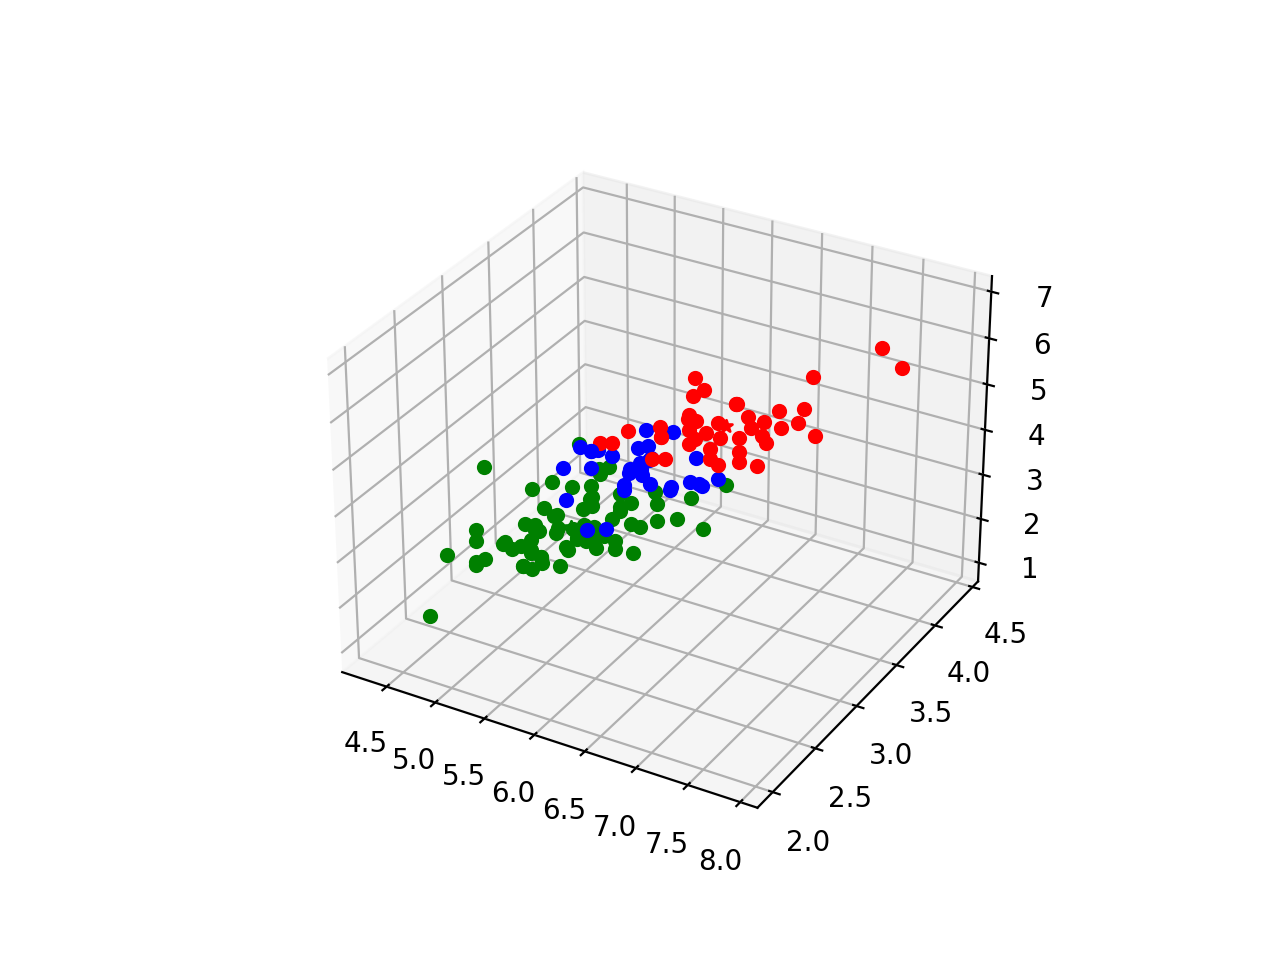

<IPython.core.display.Javascript object>


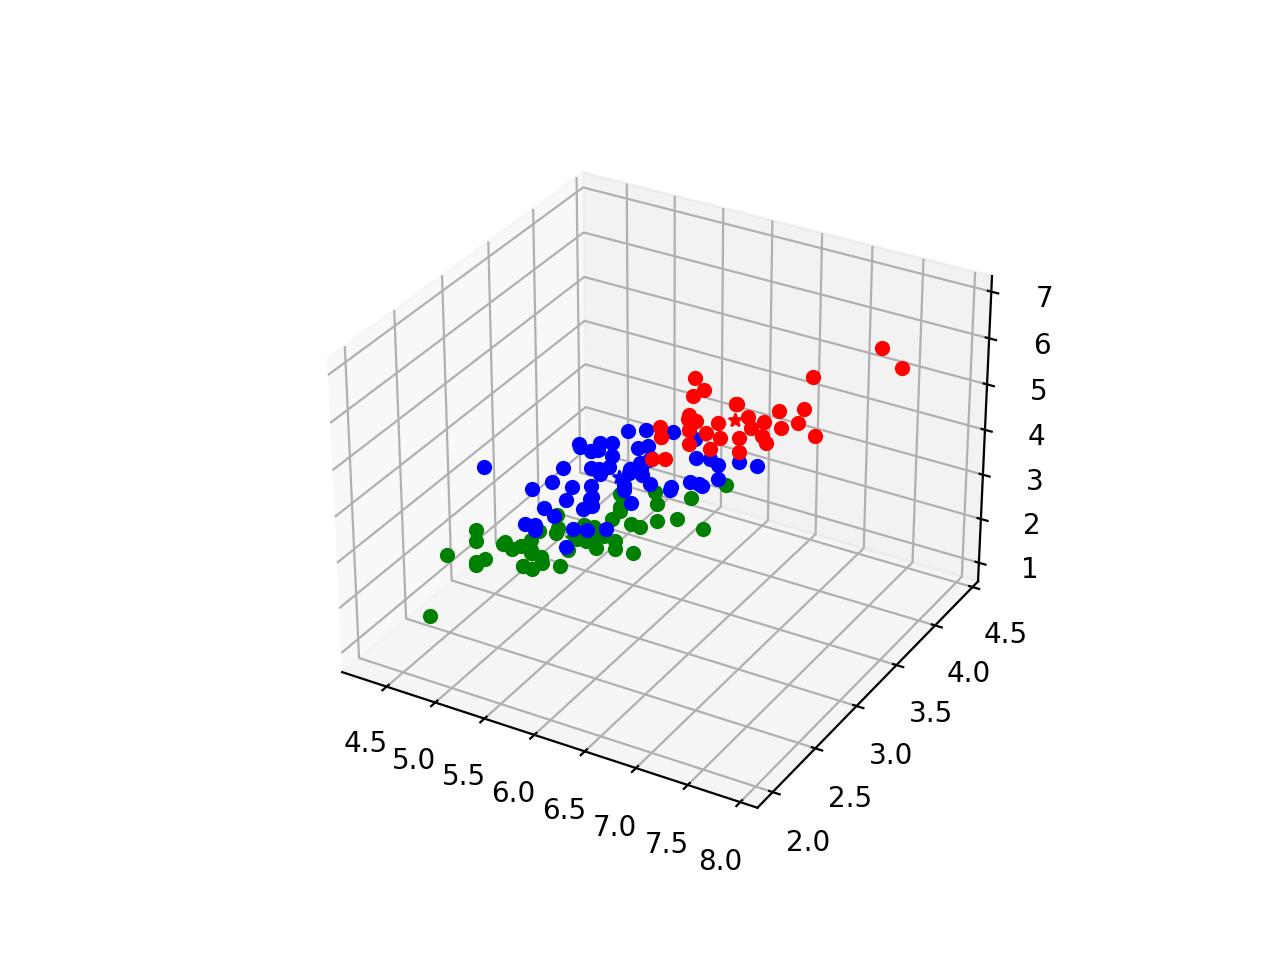

<IPython.core.display.Javascript object>


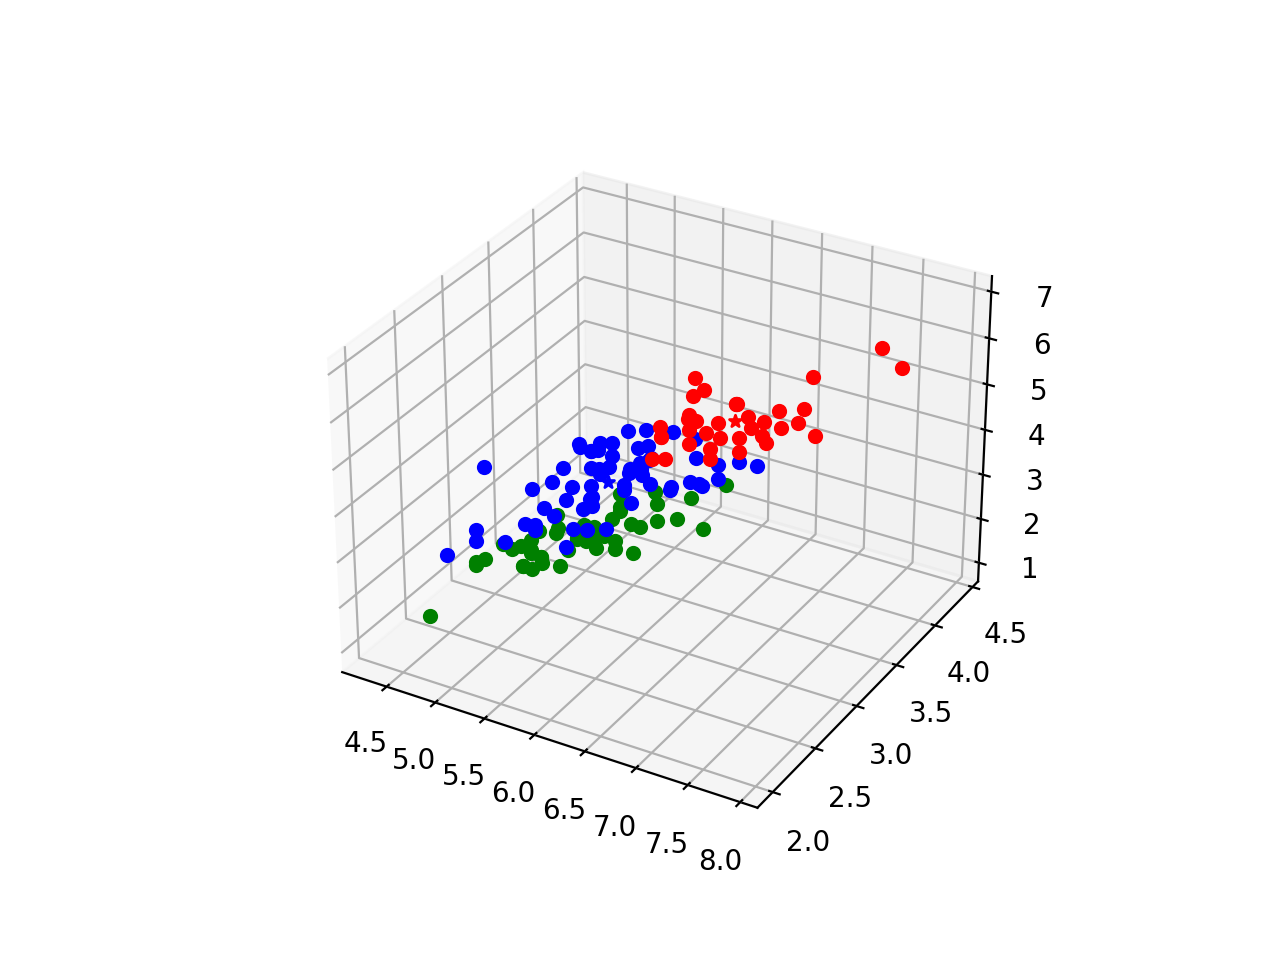

<IPython.core.display.Javascript object>


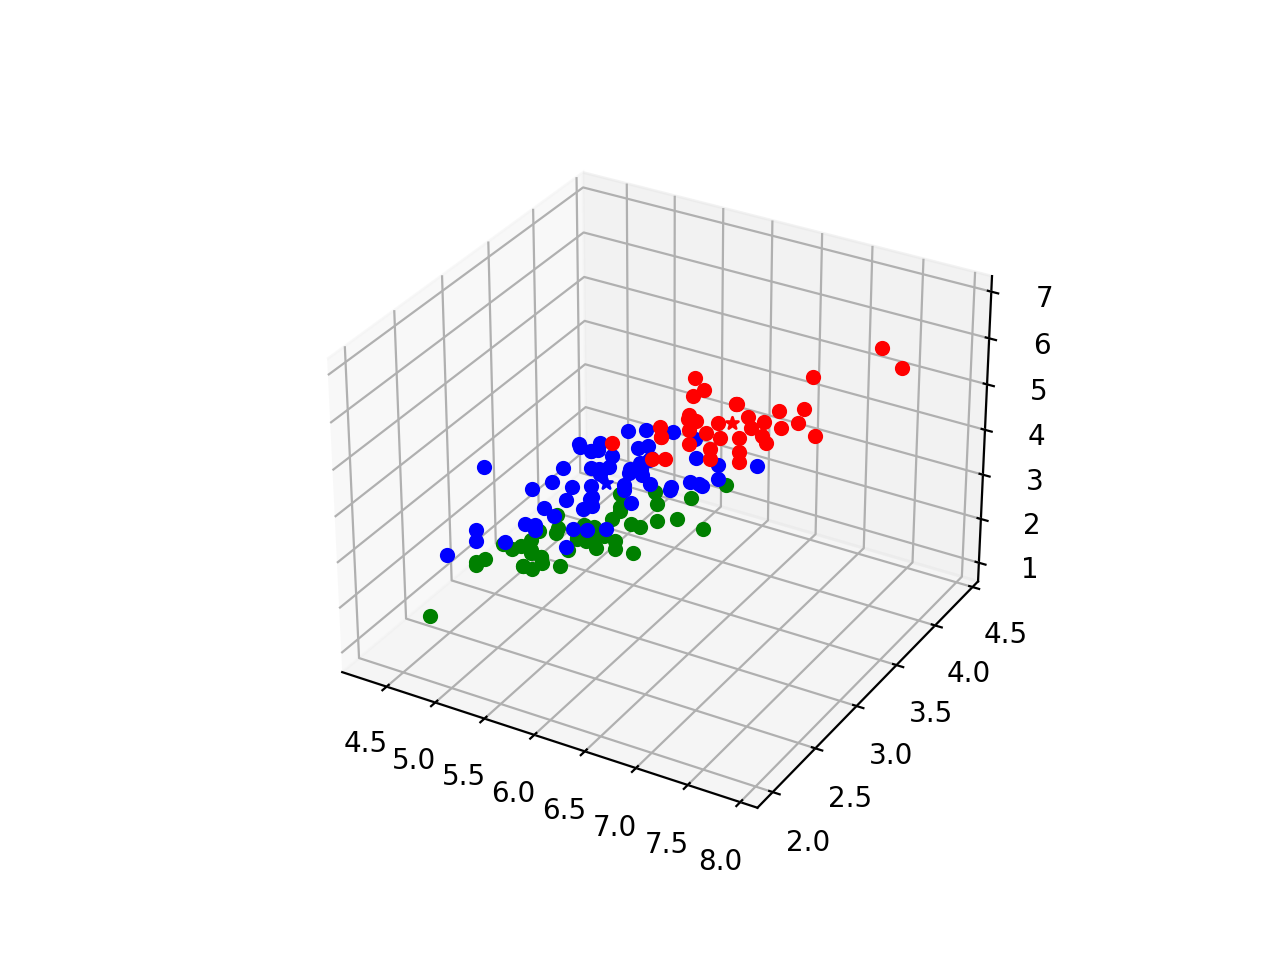

<IPython.core.display.Javascript object>


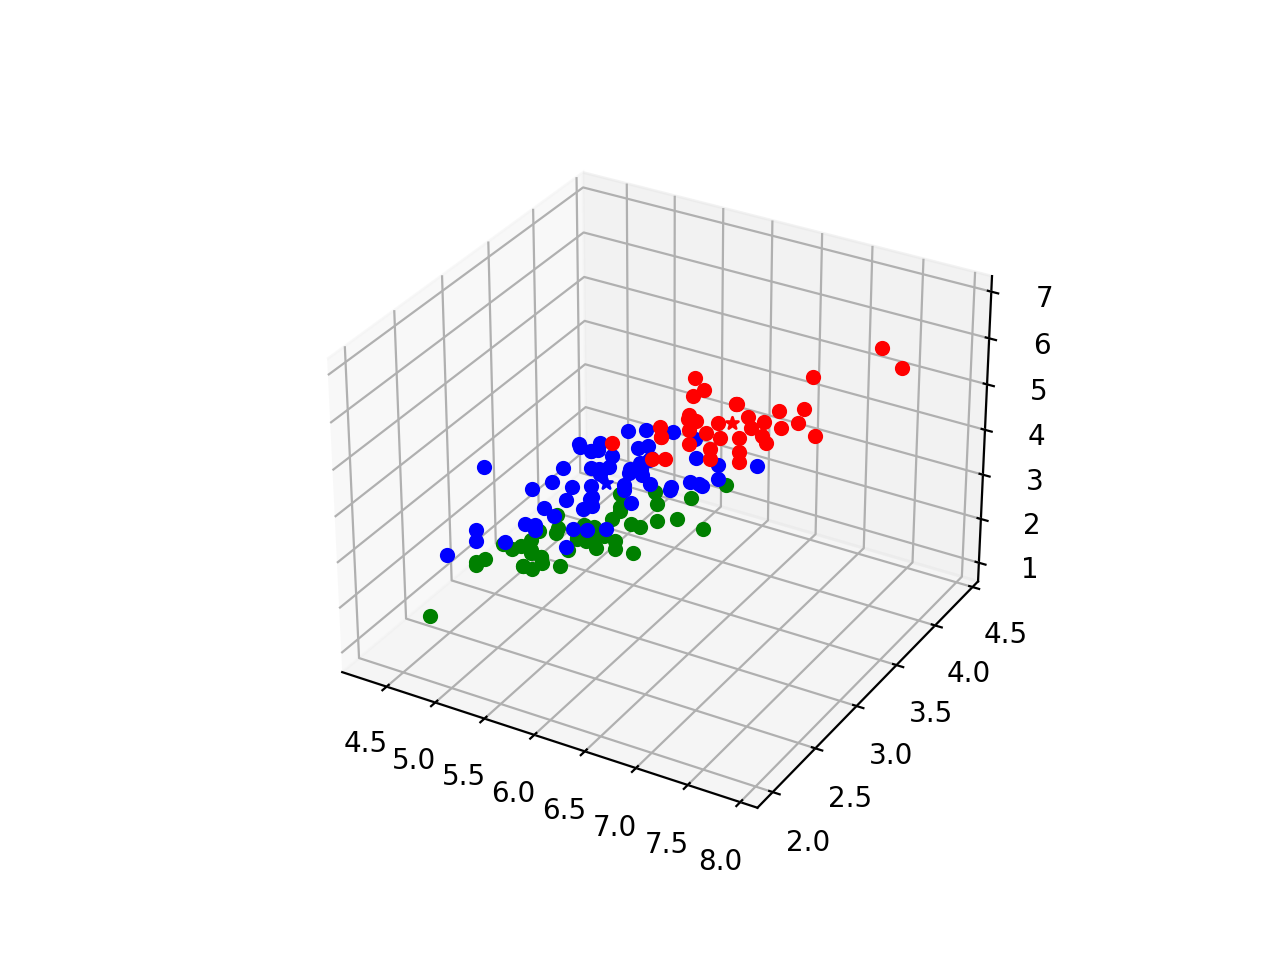

In [189]:
%matplotlib notebook

def naive_k_means(k, X, t = 100, plot = True):
    M = np.array(get_initial_centroids(k))
    
    S = None
    while (t > 0):
        
        #Get the length squared of every vector in M
        M_lengths_square = np.sum(M ** 2, axis=1)
        
        #Get the length squared of every vector in M, reshape to fit for broadcasting
        X_lengths_square = np.reshape(np.sum(X ** 2, axis=1), [X.shape[0], 1]) 
        
        #LoC formula and broadcasting M and X together
        loc_difference_lengths_square = ((M_lengths_square + X_lengths_square) -2 * (X @ M.T)).T 
        #Every row in LoC matrix contains the corresponding distance to the centroid. Using argsort, we get which centroid have the smallest distance
        closest_centroids = np.argsort(loc_difference_lengths_square, axis=0)[0] 
        
        #Stores the vectors closest to a centroid in corresponding index 0, 1 ... k-1
        S = [X[closest_centroids==i] for i in range(k)] 
        
        #Gets the mean of all the vectors belonging to centroid i
        M_new = np.array([ X[closest_centroids == i].mean(axis=0) for i in range(k)]) 
        
        if (plot):
            plot_iteration(t, M_new, S)
            
        if ((M_new == M).all()):
            break
        
        M = M_new
        t -= 1
    
    # Append the centroids to the end of S for later calculate optimal K
    S.append(M)
    return S
    
abc = naive_k_means(k, points)


## Choosing K

One obvious way of choosing K is to plot the data first, if it's plot-able. You might already see clearly defined clusters, if that's the case, a suitable K might be the number of clusters you see. 

Another method is to calculate the distances $d$ between the assigned vectors in $X$ and the centroid vectors in $C$ after K-means is done running. This method might be better for less complex datasets. 

We subtract the corresponding centroid vector $C_i$ with all corresponding assigned vectors $X_{ij}$, note that $X_i$ holds the vectors $x_j$ assigned to centroid $i$. Get the distance $d_j = X_{ij} - C_i$ and calculate the length squared $||d_j||^2$, add and repeat for every centroid summing up everything to one value $d$. With a higher $K$ value, the distance to the closest centroid $C_i$ will get smaller and smaller, eventually reaching 0 when there exist a centroid for every $X$. What's interesting to look for here is for what $K$ the rate of change starts to decrease, that might be a good indication for a fitting $K$ value. 

# $d = \displaystyle\sum_{i=1}^{k}\displaystyle\sum_{j=1}^{N} ||X_{ij} - C_i||^2$


When running below code, the initial centroids are selected randomly based on the dataset, which creates different resuts. If you run the code multiple times, in general, the last large decrease of $d$ will be from 2 to 3 and therefore, $k = 3$ seems to be a good choice which aligns well to the 3 different classes in the iris datset.  

<IPython.core.display.Javascript object>


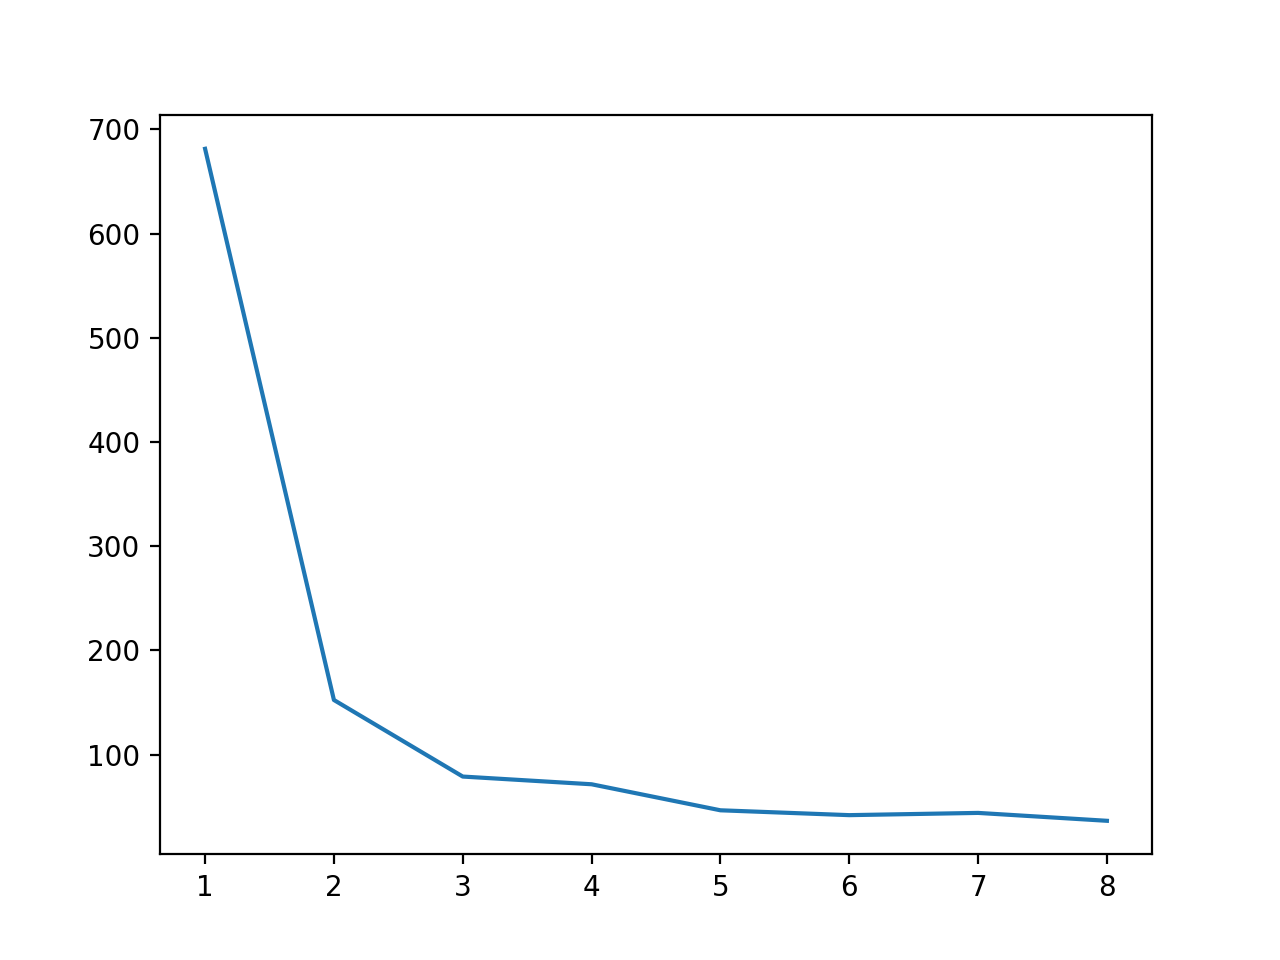

In [190]:
def calc_d(S):
    d = 0
    C = S[-1]
    X = S[:-1]
    
    for i in range(len(C)):
        for j in range(len(X[i])):
            d += ((X[i][j] - C[i]) @ (X[i][j] - C[i]))
    
    return d

def choose_k(max_k):
    k = []
    d_arr = []
    
    for i in range(1, max_k+1):
        S = naive_k_means(i, points, plot=False)
        d_arr.append(calc_d(S))
        k.append(i)
    
    plt.figure()
    plt.plot(k, d_arr)

    
    
choose_k(8)
    
    